In [13]:
import keras
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

# Example Bid Price, Moving Up

Neural network modelling p(Y = y1 |Y >= y1, X=x)

There can be zero levels both in the spread as well as in the bid and ask sides. Furthermore, many changes are happening within our 100ms snapshot window. I thus see two ways by which to calculate the price level change:

#### 1.
As the price is to 0.01 accuracy one can simply take the difference in the best bid price and multiply by 100 to get it in the terms of how many $ \$ 0.01$ levels it has increased by.
$
#### 2.
Or one can approximate the price level change by taking that which is closest to the current non-zero levels present.
 e.g. if the bid price moves up in the next step to 5.20 and at the current time step there are ask price levels at 5.15, 5.18, 5.22, ... then there will be a price level increase of 2 levels. This seems somewhat more arbitrary and heavily dependent on the current state of the orderbook.
 
$\textbf{This is one of the things I am not sure about but I have assumed the first method}$
$\textbf{of defining price level change.}$

The file "df_snapshot_100_ms_bid_up.csv" uses the first approach of seeing levels as the $\$0.01$ differences. It includes only the snapshots for which a bid price increase was observed.

In [2]:
df_bid_up = pd.read_csv('df_snapshot_100ms_bid_up.csv', index_col='timestamp')
df_bid_up.head()

,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10,...,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,bid_change_n
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-11-12 00:00:10.300,0.020000,0.093829,1.000000,0.023100,2.859000,1.083058,0.0600,1.000000,0.1000,2.45536,...,2.500,0.896321,0.001,0.766000,0.001737,1.820000,0.933419,2.297440,0.052000,1.0
2019-11-12 00:00:19.300,5.898437,0.103284,2.862000,1.000000,0.023100,4.100000,1.0000,0.100000,0.0600,2.06466,...,2.600,0.005000,2.500,1.236624,0.010000,0.001000,0.766000,0.001737,1.820000,4.0
2019-11-12 00:00:19.400,2.000000,0.881936,2.000000,4.658088,2.862000,1.000000,0.0231,4.100000,1.0000,0.10000,...,8.200,2.203000,2.600,0.005000,2.500000,1.236624,0.010000,0.001000,0.766000,3.0
2019-11-12 00:00:19.500,1.901425,2.286003,2.120276,2.000000,2.658088,2.862000,1.0000,0.103284,0.0231,4.10000,...,2.203,2.600000,0.005,2.500000,1.236624,0.010000,0.001000,0.766000,0.001737,3.0
2019-11-12 00:00:19.600,2.200000,2.000000,2.000000,2.860000,0.120276,2.658088,1.0000,0.103284,0.0231,4.10000,...,2.203,2.600000,0.005,2.500000,1.236624,0.010000,0.001000,0.766000,0.001737,4.0


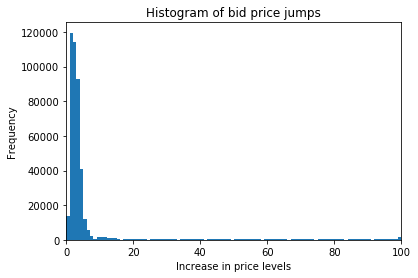

In [3]:
# Make sure to use values.astype(int) and round as otherwise 0.99 goes to 0 and many are approximately 1 but not quite for some reason. Although for bins it doens't matter.
value_counts = np.unique(np.round(df_bid_up['bid_change_n'].values).astype(int), return_counts=True)
plt.hist(df_bid_up['bid_change_n'], bins=100, range=(0,100))
plt.xlabel('Increase in price levels')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.title('Histogram of bid price jumps')
plt.show()

As the neural network models conditional probabilities, the conditional increase $y_1>=1$ is also an input to the neural network $f_\theta^{1,-}(x,y_1)$. This means for every row, n duplicates can be made with $y_1$ increasing from 1 to the amount of levels it actually moves. As can be seen in the histogram above, although in most snapshots the price level change is only around 5-10, there are some snapshots where there are increases of 100 or more (max price level change is 2733 (see value_counts)). Duplicating that many rows seems somewhat bad so I could simply duplicate the rows of those snapshots that only increase by say max 20 price levels. This would however have a big effect on the accuracy of the model in the tails of the distribution. As this is of particular importance in risk modelling, this isn't a great way to do it I think.
$\textbf{This is the second thing I'm not really sure about}$

In order to advance however, I will cap the duplication of the rows of snapshots to 20.:

In [4]:
# Drop the timestamp as this is not important
df_bid_up.reset_index(drop=True, inplace=True)

# Round the bid_change_n to the nearest integer than convert type to int
df_bid_up['bid_change_n'] = np.round(df_bid_up['bid_change_n'].values).astype(int)

# Cap the duplication to 20 rows
reps = np.clip(df_bid_up['bid_change_n'].values,a_min=1, a_max=20)

# List of indices, if want to repeat twice will appear twice but max 20x.
df_bid_up_reps = df_bid_up.loc[np.repeat(df_bid_up.index.values, reps)]

In [5]:
# Cap the duplication to 20 rows
reps = np.clip(df_bid_up['bid_change_n'].values,a_min=1, a_max=20)

# List of indices, if want to repeat twice will appear twice but max 20x.
df_bid_up_reps = df_bid_up.loc[np.repeat(df_bid_up.index.values, reps)]

# Forming y1_cond from the bid change_n, add to dataframe
y1_cond = [ind for val in df_bid_up['bid_change_n'].values for ind in list(range(1,min(20,val)+1))]
df_bid_up_reps['y1_cond'] = y1_cond

#Reset index
df_bid_up_reps.reset_index(drop=True, inplace=True)

In [7]:
del df_bid_up

In [6]:
df_bid_up_reps

,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10,...,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,bid_change_n,y1_cond
0,0.020000,0.093829,1.000000,0.023100,2.859000,1.083058,0.060,1.000000,0.100,2.45536,...,0.896321,0.001000,0.766000,0.001737,1.820,0.933419,2.297440,0.052,1,1
1,5.898437,0.103284,2.862000,1.000000,0.023100,4.100000,1.000,0.100000,0.060,2.06466,...,0.005000,2.500000,1.236624,0.010000,0.001,0.766000,0.001737,1.820,4,1
2,5.898437,0.103284,2.862000,1.000000,0.023100,4.100000,1.000,0.100000,0.060,2.06466,...,0.005000,2.500000,1.236624,0.010000,0.001,0.766000,0.001737,1.820,4,2
3,5.898437,0.103284,2.862000,1.000000,0.023100,4.100000,1.000,0.100000,0.060,2.06466,...,0.005000,2.500000,1.236624,0.010000,0.001,0.766000,0.001737,1.820,4,3
4,5.898437,0.103284,2.862000,1.000000,0.023100,4.100000,1.000,0.100000,0.060,2.06466,...,0.005000,2.500000,1.236624,0.010000,0.001,0.766000,0.001737,1.820,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999931,0.455383,2.000000,7.000000,0.044613,5.877000,0.193134,3.087,0.021600,4.500,0.06000,...,0.020000,9.553161,0.600000,0.667000,1.444,2.000000,0.005800,4.580,3,3
1999932,2.000000,5.000000,2.000000,2.000000,0.044613,5.877000,0.200,0.193134,3.087,0.02160,...,2.400000,0.741490,0.020000,9.553161,0.600,0.667000,1.444000,2.000,2,1
1999933,2.000000,5.000000,2.000000,2.000000,0.044613,5.877000,0.200,0.193134,3.087,0.02160,...,2.400000,0.741490,0.020000,9.553161,0.600,0.667000,1.444000,2.000,2,2
1999934,7.000000,2.000000,0.044613,5.877000,0.200000,0.193134,3.087,0.021600,4.500,0.06000,...,0.001000,0.001000,2.400000,0.741490,0.020,9.553161,0.600000,0.667,2,1


This is now the full dataframe in theory (I think) with the bid_change_n being the y variable and the rest the X dataframe.

In [8]:
X = df_bid_up_reps.drop('bid_change_n', axis=1)
y = df_bid_up_reps['bid_change_n']

X.head()

,bq1,bq2,bq3,bq4,bq5,bq6,bq7,bq8,bq9,bq10,...,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,y1_cond
0,0.020000,0.093829,1.000,0.0231,2.8590,1.083058,0.06,1.0,0.10,2.45536,...,2.5,0.896321,0.001,0.766000,0.001737,1.820,0.933419,2.297440,0.052,1
1,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,1
2,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,2
3,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,3
4,5.898437,0.103284,2.862,1.0000,0.0231,4.100000,1.00,0.1,0.06,2.06466,...,2.6,0.005000,2.500,1.236624,0.010000,0.001,0.766000,0.001737,1.820,4


Now I would implement a neural network for classification with the price level increase being the classes. Don't really think this is what Sirignano meant? It means there are a lot of classes! But don't not sure how else to then supply the X_train and y_train variables. 

2 million data points seemed to be too much as it caused a memory error so take an eigth:

In [9]:
X = X[0:int(len(X)/8)]
y = y[0:int(len(y)/8)]

In [10]:
y_cat = to_categorical(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y_cat,
                                                    test_size=0.2)